<a href="https://colab.research.google.com/github/timhalter/PA-Addee/blob/main/PA_Addee_Emotion_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
!pip install transformers
!pip install NRCLex

     |████████████████████████████████| 3.4 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 55.0 MB/s 
     |████████████████████████████████| 3.3 MB 49.2 MB/s 
     |████████████████████████████████| 895 kB 55.6 MB/s 
     |████████████████████████████████| 61 kB 482 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 396 kB 4.0 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43328 sha256=416463b0df4f576afc3bd7d9b03362d22d13e01af552d41c85e3aaba7721594e
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


**Import NLTK** 

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd
import numpy as np
from nrclex import NRCLex
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import class_weight # maybe not needed

from keras import Sequential
from keras.layers import Dense,LSTM,Input,Dropout,SimpleRNN
from keras import backend as K
import matplotlib.pyplot as plt

**Loss Function**

In [4]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

**Read dataset**

In [75]:
url = 'https://raw.githubusercontent.com/timhalter/PA-Addee/main/children_stories.Csv'
df = pd.read_csv(url,encoding='ISO-8859-1')

df.head()

,names,cats,desc
0,HIDE AND SEEK,Age 2-9,Was it just another game of hide and seek? No....
1,GINGER THE GIRAFFE,Age 2-9,Read this warm tale of camaraderie and affecti...
2,DOING MY CHORES,Age 2-9,Love shines through this great illustrated kid...
3,ABE THE SERVICE DOG,Age 2-9,Abe was a real Service Dog who dedicated his l...
4,SUNNY MEADOWS WOODLAND SCHOOL,Age 2-9,The class took a little train and went deep in...


Übersicht der Altersklassen:

In [76]:
df['cats'].value_counts().sort_index()



Age              2
Age  0-3         1
Age 0+          13
Age 0-2          2
Age 0-3         11
Age 0-4         16
Age 0-5          8
Age 0-6          1
Age 1+           2
Age 1-2          1
Age 1-3          6
Age 1-4          4
Age 1-5          5
Age 1-6          1
Age 10+         26
Age 10-14        1
Age 11+         19
Age 11-14        1
Age 11-15        1
Age 12+         12
Age 13+          3
Age 2+          12
Age 2-4          1
Age 2-5          9
Age 2-6         10
Age 2-7          1
Age 2-9         20
Age 3+          32
Age 3-4          1
Age 3-5          7
Age 3-6          9
Age 3-7          5
Age 4+          20
Age 4-11         1
Age 4-5          1
Age 4-6          3
Age 4-7          2
Age 4-8          3
Age 5+          17
Age 5-8          3
Age 5-9          2
Age 6+          21
Age 6-11         3
Age 6-8          2
Age 6-9          1
Age 6months+     1
Age 7+          27
Age 7-10         2
Age 7-11         4
Age 7-12         1
Age 7-9          2
Age 8+          26
Age 8-11    

Es gibt eine Altersklasse ohne Altersangabe, die nun entfernt werden soll:

In [77]:
df = df.drop(df.query("cats == 'Age '").index, axis=0).reset_index(drop=True)

(Split cats in min_age und max_age)

In [78]:
def min_age(sir):
    if sir.find('+')!=-1:
        if sir.find('months+')!=-1:
          return np.int(sir[:sir.find('months+')])
        else:
          return np.int(sir[:sir.find('+')])
    elif sir.find('-')!=-1:
        return np.int(sir.split('-')[0])
    elif bool(re.match(r'[0-9]+',sir)):
        return np.int(sir)
    else:
        return 'else'

df['cats'] = df['cats'].str.replace('Age ', '')
df['Min_Age'] = df.cats.apply(min_age)
df.head()

,names,cats,desc,Min_Age
0,HIDE AND SEEK,2-9,Was it just another game of hide and seek? No....,2
1,GINGER THE GIRAFFE,2-9,Read this warm tale of camaraderie and affecti...,2
2,DOING MY CHORES,2-9,Love shines through this great illustrated kid...,2
3,ABE THE SERVICE DOG,2-9,Abe was a real Service Dog who dedicated his l...,2
4,SUNNY MEADOWS WOODLAND SCHOOL,2-9,The class took a little train and went deep in...,2


In [79]:
df['Min_Age'].value_counts().sort_index()

0     52
1     19
2     53
3     54
4     30
5     22
6     28
7     36
8     31
9     40
10    27
11    21
12    12
13     3
Name: Min_Age, dtype: int64

Wir erstellen mehrere Listen, welche verschiedene Altersklassen unterscheiden sollen:

In [92]:
fsk_0 = [0, 0.0, 1, 1.0, 2, 2.0, 3, 3.0]
fsk_4 = [4, 4.0, 5, 5.0, 6, 6.0, 7, 7.0, 8, 8.0]
fsk_9 = [9, 9.0, 10, 10.0, 11, 11.0, 12, 12.0, 13, 13.0]

In [93]:
df['FSK_Group'] = df['Min_Age'].apply(lambda age: 0 if age in fsk_0 else 
                                                    (1 if age in fsk_4 else 
                                                      (2 if age in fsk_9 else -1)))

df.head(10)

,names,cats,desc,Min_Age,FSK_Group
0,HIDE AND SEEK,2-9,Was it just another game of hide and seek? No....,2,0
1,GINGER THE GIRAFFE,2-9,Read this warm tale of camaraderie and affecti...,2,0
2,DOING MY CHORES,2-9,Love shines through this great illustrated kid...,2,0
3,ABE THE SERVICE DOG,2-9,Abe was a real Service Dog who dedicated his l...,2,0
4,SUNNY MEADOWS WOODLAND SCHOOL,2-9,The class took a little train and went deep in...,2,0
5,TOOTH FAIRY,2-9,A wonderful story that weaves its magic in the...,2,0
6,HAMMY THE HAMSTER,2-9,Heâs got swag. He wears a tux. Heâs a hips...,2,0
7,THE CASE OF THE MISSING SMILE,2-9,Detective Peterson is trying to find where Sal...,2,0
8,HOMEWORK - YUCK!,2-9,Jamal made a case at the next open house and i...,2,0
9,CAPTAIN FANTASTIC,2-9,"Dr. Zobâs evil plans had failed once again,...",2,0


Übersicht der Altersverteilung:
- Es ist ersichtlich, dass die Altersklassen ziemlich unbalanciert sind.

In [94]:
df['FSK_Group'].value_counts().sort_index()

0    178
1    147
2    103
Name: FSK_Group, dtype: int64

**Preprocessing**

In [95]:
def process_text(text):    
    # Remove digits
    text = re.sub(r'\d+', ' ', text)    
    # Split on whitespace
    text = text.split()    
    # Join on whitespace, but only the words that are not stop words
    text = ' '.join([word for word in text if word not in stopwords.words('english')])        
    return text

# Sonderzeichen entfernen
df['desc'] = df['desc'].apply(lambda x: ''.join(re.sub(r'\W', ' ', x)))
# Doppel-Leerschläge entfernen
df['desc'] = df['desc'].apply(lambda x: ''.join(re.sub(r'\s+', ' ', x, flags=re.I)))
# Lowercase
df['desc'] = df['desc'].str.lower()

df['desc'] = df['desc'].copy().apply(process_text)

In [14]:
df.head(5)

,names,cats,desc,Min_Age,Max_Age,FSK_Group
0,HIDE AND SEEK,2-9,another game hide seek first fell deep dark ho...,2,9,1
1,GINGER THE GIRAFFE,2-9,read warm tale camaraderie affection set wild ...,2,9,1
2,DOING MY CHORES,2-9,love shines great illustrated kidsâ book read ...,2,9,1
3,ABE THE SERVICE DOG,2-9,abe real service dog dedicated life assisting ...,2,9,1
4,SUNNY MEADOWS WOODLAND SCHOOL,2-9,class took little train went deep woods first ...,2,9,1


In [96]:
df['Min_Age'].value_counts().sort_index()

0     52
1     19
2     53
3     54
4     30
5     22
6     28
7     36
8     31
9     40
10    27
11    21
12    12
13     3
Name: Min_Age, dtype: int64

Emotion-Detection mit NRCLex:


In [110]:
def getEmotionFreq(emotion):
  eArr = np.zeros(11)
  for i, val in enumerate(emotion.values()):
    eArr[i] = val
  return eArr

fear = []
anger = []
trust = []
surprise = []
positive = []
negative = []
sadness = []
disgust = []
joy = []
anticipation = []

for idx, row in df.iterrows():
  text = row['desc']
  emotion = NRCLex(text).affect_frequencies
  emotions = getEmotionFreq(emotion)
  
  fear.append(emotions[0])
  anger.append(emotions[1])
  trust.append(emotions[3])
  surprise.append(emotions[4])
  positive.append(emotions[5])
  negative.append(emotions[6])
  sadness.append(emotions[7])
  disgust.append(emotions[8])
  joy.append(emotions[9])
  anticipation.append(emotions[10])

df['fear'] = fear
df['anger'] = anger
df['trust'] = trust
df['surprise'] = surprise
df['positive'] = positive
df['negative'] = negative
df['sadness'] = sadness
df['disgust'] = disgust
df['joy'] = joy
df['anticipation'] = anticipation
df.head(10)

,names,cats,desc,Min_Age,FSK_Group,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,HIDE AND SEEK,2-9,another game hide seek first fell deep dark ho...,2,0,0.043478,0.000000,0.130435,0.086957,0.217391,0.043478,0.086957,0.000000,0.173913,0.217391
1,GINGER THE GIRAFFE,2-9,read warm tale camaraderie affection set wild ...,2,0,0.125000,0.000000,0.125000,0.062500,0.312500,0.062500,0.000000,0.000000,0.187500,0.125000
2,DOING MY CHORES,2-9,love shines great illustrated kidsâ book read ...,2,0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333
3,ABE THE SERVICE DOG,2-9,abe real service dog dedicated life assisting ...,2,0,0.000000,0.000000,0.250000,0.050000,0.400000,0.000000,0.000000,0.000000,0.150000,0.150000
4,SUNNY MEADOWS WOODLAND SCHOOL,2-9,class took little train went deep woods first ...,2,0,0.090909,0.000000,0.181818,0.181818,0.181818,0.090909,0.000000,0.000000,0.090909,0.181818
5,TOOTH FAIRY,2-9,wonderful story weaves magic childâ imaginatio...,2,0,0.000000,0.000000,0.181818,0.090909,0.272727,0.000000,0.000000,0.000000,0.181818,0.272727
6,HAMMY THE HAMSTER,2-9,heâ got swag wears tux heâ hipster hamster lik...,2,0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,THE CASE OF THE MISSING SMILE,2-9,detective peterson trying find sally sue lost ...,2,0,0.000000,0.055556,0.111111,0.166667,0.222222,0.166667,0.111111,0.000000,0.166667,0.000000
8,HOMEWORK - YUCK!,2-9,jamal made case next open house mattered much ...,2,0,0.066667,0.000000,0.266667,0.066667,0.333333,0.066667,0.066667,0.000000,0.066667,0.066667
9,CAPTAIN FANTASTIC,2-9,dr zobâ evil plans failed thanks wonder dog wi...,2,0,0.055556,0.055556,0.111111,0.111111,0.277778,0.055556,0.055556,0.055556,0.166667,0.055556


In der Tabelle oben sieht man, dass sehr viele 0 Werte vorhanden sind. Diese 0 Werte sollen nun mit dem Mittelwert der entsprechenden Altersklasse ersetzt werden.

In [121]:
df['fear'] = df['fear'].replace(0, np.NaN)
df['anger'] = df['anger'].replace(0, np.NaN)
df['trust'] = df['trust'].replace(0, np.NaN)
df['surprise'] = df['surprise'].replace(0, np.NaN)
df['positive'] = df['positive'].replace(0, np.NaN)
df['negative'] = df['negative'].replace(0, np.NaN)
df['sadness'] = df['sadness'].replace(0, np.NaN)
df['disgust'] = df['disgust'].replace(0, np.NaN)
df['joy'] = df['joy'].replace(0, np.NaN)
df['anticipation'] = df['anticipation'].replace(0, np.NaN)
df.head(10)

,names,cats,desc,Min_Age,FSK_Group,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,HIDE AND SEEK,2-9,another game hide seek first fell deep dark ho...,2,0,0.043478,NaN,0.130435,0.086957,0.217391,0.043478,0.086957,NaN,0.173913,0.217391
1,GINGER THE GIRAFFE,2-9,read warm tale camaraderie affection set wild ...,2,0,0.125000,NaN,0.125000,0.062500,0.312500,0.062500,NaN,NaN,0.187500,0.125000
2,DOING MY CHORES,2-9,love shines great illustrated kidsâ book read ...,2,0,NaN,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,0.333333,0.333333
3,ABE THE SERVICE DOG,2-9,abe real service dog dedicated life assisting ...,2,0,NaN,NaN,0.250000,0.050000,0.400000,NaN,NaN,NaN,0.150000,0.150000
4,SUNNY MEADOWS WOODLAND SCHOOL,2-9,class took little train went deep woods first ...,2,0,0.090909,NaN,0.181818,0.181818,0.181818,0.090909,NaN,NaN,0.090909,0.181818
5,TOOTH FAIRY,2-9,wonderful story weaves magic childâ imaginatio...,2,0,NaN,NaN,0.181818,0.090909,0.272727,NaN,NaN,NaN,0.181818,0.272727
6,HAMMY THE HAMSTER,2-9,heâ got swag wears tux heâ hipster hamster lik...,2,0,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
7,THE CASE OF THE MISSING SMILE,2-9,detective peterson trying find sally sue lost ...,2,0,NaN,0.055556,0.111111,0.166667,0.222222,0.166667,0.111111,NaN,0.166667,NaN
8,HOMEWORK - YUCK!,2-9,jamal made case next open house mattered much ...,2,0,0.066667,NaN,0.266667,0.066667,0.333333,0.066667,0.066667,NaN,0.066667,0.066667
9,CAPTAIN FANTASTIC,2-9,dr zobâ evil plans failed thanks wonder dog wi...,2,0,0.055556,0.055556,0.111111,0.111111,0.277778,0.055556,0.055556,0.055556,0.166667,0.055556


In [122]:
df['fear'] = df['fear'].replace(np.NaN, df['fear'].mean())
df['anger'] = df['anger'].replace(np.NaN, df['anger'].mean())
df['trust'] = df['trust'].replace(np.NaN, df['trust'].mean())
df['surprise'] = df['surprise'].replace(np.NaN, df['surprise'].mean())
df['positive'] = df['positive'].replace(np.NaN, df['positive'].mean())
df['negative'] = df['negative'].replace(np.NaN, df['negative'].mean())
df['sadness'] = df['sadness'].replace(np.NaN, df['sadness'].mean())
df['disgust'] = df['disgust'].replace(np.NaN, df['disgust'].mean())
df['joy'] = df['joy'].replace(np.NaN, df['joy'].mean())
df['anticipation'] = df['anticipation'].replace(np.NaN, df['anticipation'].mean())
df.head(10)

,names,cats,desc,Min_Age,FSK_Group,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,HIDE AND SEEK,2-9,another game hide seek first fell deep dark ho...,2,0,0.043478,0.066596,0.130435,0.086957,0.217391,0.043478,0.086957,0.060490,0.173913,0.217391
1,GINGER THE GIRAFFE,2-9,read warm tale camaraderie affection set wild ...,2,0,0.125000,0.066596,0.125000,0.062500,0.312500,0.062500,0.069257,0.060490,0.187500,0.125000
2,DOING MY CHORES,2-9,love shines great illustrated kidsâ book read ...,2,0,0.082546,0.066596,0.132738,0.077110,0.333333,0.119217,0.069257,0.060490,0.333333,0.333333
3,ABE THE SERVICE DOG,2-9,abe real service dog dedicated life assisting ...,2,0,0.082546,0.066596,0.250000,0.050000,0.400000,0.119217,0.069257,0.060490,0.150000,0.150000
4,SUNNY MEADOWS WOODLAND SCHOOL,2-9,class took little train went deep woods first ...,2,0,0.090909,0.066596,0.181818,0.181818,0.181818,0.090909,0.069257,0.060490,0.090909,0.181818
5,TOOTH FAIRY,2-9,wonderful story weaves magic childâ imaginatio...,2,0,0.082546,0.066596,0.181818,0.090909,0.272727,0.119217,0.069257,0.060490,0.181818,0.272727
6,HAMMY THE HAMSTER,2-9,heâ got swag wears tux heâ hipster hamster lik...,2,0,0.082546,0.066596,0.132738,0.077110,1.000000,0.119217,0.069257,0.060490,0.145771,0.133865
7,THE CASE OF THE MISSING SMILE,2-9,detective peterson trying find sally sue lost ...,2,0,0.082546,0.055556,0.111111,0.166667,0.222222,0.166667,0.111111,0.060490,0.166667,0.133865
8,HOMEWORK - YUCK!,2-9,jamal made case next open house mattered much ...,2,0,0.066667,0.066596,0.266667,0.066667,0.333333,0.066667,0.066667,0.060490,0.066667,0.066667
9,CAPTAIN FANTASTIC,2-9,dr zobâ evil plans failed thanks wonder dog wi...,2,0,0.055556,0.055556,0.111111,0.111111,0.277778,0.055556,0.055556,0.055556,0.166667,0.055556


Die Emotions-Spalten werden nun zu einem Numpy Array zusammengefasst:

In [123]:
df_merged = np.stack([df.fear.to_numpy(), 
                      df.anger.to_numpy(), 
                      df.trust.to_numpy(), 
                      df.surprise.to_numpy(), 
                      df.positive.to_numpy(), 
                      df.negative.to_numpy(), 
                      df.sadness.to_numpy(), 
                      df.disgust.to_numpy(),
                      df.joy.to_numpy(),
                      df.anticipation.to_numpy()], axis=1)
df_merged

array([[0.04347826, 0.06659604, 0.13043478, ..., 0.06049039, 0.17391304,
        0.2173913 ],
       [0.125     , 0.06659604, 0.125     , ..., 0.06049039, 0.1875    ,
        0.125     ],
       [0.08254572, 0.06659604, 0.13273772, ..., 0.06049039, 0.33333333,
        0.33333333],
       ...,
       [0.02857143, 0.05714286, 0.17142857, ..., 0.02857143, 0.11428571,
        0.11428571],
       [0.12      , 0.06      , 0.08      , ..., 0.06      , 0.08      ,
        0.1       ],
       [0.14285714, 0.06659604, 0.28571429, ..., 0.06049039, 0.07142857,
        0.14285714]])

Train/Test split:

In [124]:
train_x_min,test_x_min,train_y_min,test_y_min = train_test_split(df_merged,df.FSK_Group.astype(np.float32))

Klassen balancieren durch oversampling:

In [125]:
from collections import Counter
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(train_x_min, train_y_min)
print(f"Training target statistics: { Counter(y_res) }")
print(f"Testing target statistics: { Counter(test_y_min) }")

Training target statistics: Counter({0.0: 133, 2.0: 133, 1.0: 133})
Testing target statistics: Counter({0.0: 45, 1.0: 33, 2.0: 29})


In [115]:
X_res.shape[1]

10

In [126]:
min_age_model = Sequential()
min_age_model.add(Input(X_res.shape[1]))
min_age_model.add(Dense(150,activation='linear'))
min_age_model.add(Dense(100,activation='linear'))
min_age_model.add(Dense(50,activation='linear'))
min_age_model.add(Dense(20,activation='linear'))
min_age_model.add(Dense(1,activation='linear'))

min_age_model.compile(optimizer='adam',loss=root_mean_squared_error, metrics='accuracy')
min_age_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 150)               1650      
                                                                 
 dense_51 (Dense)            (None, 100)               15100     
                                                                 
 dense_52 (Dense)            (None, 50)                5050      
                                                                 
 dense_53 (Dense)            (None, 20)                1020      
                                                                 
 dense_54 (Dense)            (None, 1)                 21        
                                                                 
Total params: 22,841
Trainable params: 22,841
Non-trainable params: 0
_________________________________________________________________


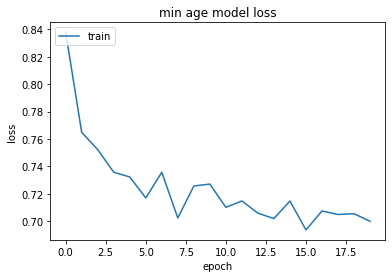

In [127]:
history = min_age_model.fit(X_res,y_res,shuffle = True,epochs=16,batch_size=4, verbose=0) # class_weight=class_weights

plt.plot(history.history['loss'])
plt.title('min age model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()



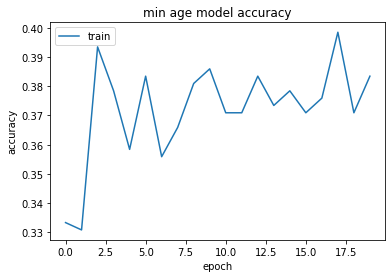

In [128]:
plt.plot(history.history['accuracy'])
plt.title('min age model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [129]:
pred = pd.DataFrame({'Pred':np.round(min_age_model.predict(test_x_min).squeeze(),0),'True':test_y_min})
pred.head(10)


,Pred,True
301,1.0,1.0
33,1.0,0.0
322,1.0,1.0
41,1.0,0.0
7,1.0,0.0
374,1.0,2.0
312,2.0,2.0
266,2.0,1.0
153,0.0,0.0
191,1.0,0.0


In [130]:
pred['True'].value_counts().sort_index()

0.0    45
1.0    33
2.0    29
Name: True, dtype: int64

In [131]:
pred['Pred'].value_counts().sort_index()

-1.0     1
 0.0    12
 1.0    84
 2.0    10
Name: Pred, dtype: int64

In [132]:
score, acc = min_age_model.evaluate(X_res, y_res, batch_size=8)

50/50 [==============================] - 0s 1ms/step - loss: 0.7008 - accuracy: 0.3860
